In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import pickle
from time import ctime
import matplotlib.pyplot as plt
import math
import warnings
#import pyomo.environ as pyo
#from pyomo.opt import SolverFactory
#from pyomo.core.base import Constraint as pyo_constraint
#from pyomo.core.base import Var as pyo_vars

### Data processing functions

In [2]:
def load_input_data(input_data, input_file_location=None):
    """
    Return input data as numpy arrays in a dictionary.
    """

    # parse the input
    lines = input_data.split('\n')

    firstLine = lines[0].split()
    num_dropoffs = int(firstLine[0]) - 1
    num_vehicles = int(firstLine[1])
    vehicle_capacity = int(firstLine[2])
    
    data_dict = {}
    data_dict['num_dropoffs'] = num_dropoffs
    data_dict['num_vehicles'] = num_vehicles
    data_dict['vehicle_capacity'] = vehicle_capacity
    data_dict['warehouse_location'] = np.array([float(lines[1].split()[1]), float(lines[1].split()[2])])
    
    dropoffs_location_array = np.zeros((num_dropoffs, 2))
    dropoffs_demand_array = np.zeros(num_dropoffs)
    
    for i in range(num_dropoffs):
        line = lines[i + 2]
        parts = line.split()
        dropoffs_demand_array[i] = parts[0]
        dropoffs_location_array[i, :] = np.array([parts[1], parts[2]])
        
    data_dict['dropoffs_location_array'] = dropoffs_location_array
    data_dict['dropoffs_demand_array'] = dropoffs_demand_array
    
    return data_dict

In [3]:
#input_file = open('data/vrp_200_16_1','r').read()
input_file = open('data/vrp_16_3_1','r').read()

In [4]:
data_dict = load_input_data(input_file)
data_dict

{'num_dropoffs': 15,
 'num_vehicles': 3,
 'vehicle_capacity': 90,
 'warehouse_location': array([30., 40.]),
 'dropoffs_location_array': array([[37., 52.],
        [49., 49.],
        [52., 64.],
        [20., 26.],
        [40., 30.],
        [21., 47.],
        [17., 63.],
        [31., 62.],
        [52., 33.],
        [51., 21.],
        [42., 41.],
        [31., 32.],
        [ 5., 25.],
        [12., 42.],
        [36., 16.]]),
 'dropoffs_demand_array': array([ 7., 30., 16.,  9., 21., 15., 19., 23., 11.,  5., 19., 29., 23.,
        21., 10.])}

In [3]:
def prepare_output_data(results_dict, is_provably_optimal=False):
    """
    Return output in specified format.
    """
    
    if is_provably_optimal:
        optimal = str(1)
    else:
        optimal = str(0)
        
    vehicle_dropoffs_dict = results_dict['vehicle_dropoffs_dict']
    
    output_data = str(results_dict['route_cost']) + ' ' + optimal + '\n'
    unused_vehicle_count = 0
    for idx, route_list in vehicle_dropoffs_dict.items():
        if route_list != [0, 0]:
            output_data += ' '.join(map(str, route_list)) + '\n'
        else:
            unused_vehicle_count += 1
            
    for i in range(unused_vehicle_count):
        output_data += '0 0' + '\n'
    
    return output_data

In [48]:
results_dict

{'vehicle_dropoffs_dict': {0: [0, 1, 3, 8, 7, 6, 0],
  1: [0, 12, 9, 2, 11, 0],
  2: [0, 5, 10, 15, 4, 13, 14, 0]},
 'route_cost': 278.72629974784724}

In [51]:
prepare_output_data(results_dict)

'278.72629974784724 0\n0 1 3 8 7 6 0\n0 12 9 2 11 0\n0 5 10 15 4 13 14 0\n'

In [4]:
def create_node_dist_matrix(data_dict):
    
    """
    Distance matrix between the warehouse and dropoffs.
    """
    
    node_array = np.concatenate((np.array([data_dict['warehouse_location']]), data_dict['dropoffs_location_array']))
    
    return cdist(node_array, node_array)

In [8]:
node_dist_matrix = create_node_dist_matrix(data_dict)
node_dist_matrix

array([[ 0.        , 13.89244399, 21.02379604, 32.55764119, 17.20465053,
        14.14213562, 11.40175425, 26.41968963, 22.02271555, 23.08679276,
        28.31960452, 12.04159458,  8.06225775, 29.15475947, 18.11077028,
        24.73863375],
       [13.89244399,  0.        , 12.36931688, 19.20937271, 31.06444913,
        22.20360331, 16.76305461, 22.82542442, 11.66190379, 24.20743687,
        34.0147027 , 12.08304597, 20.88061302, 41.86884283, 26.92582404,
        36.01388621],
       [21.02379604, 12.36931688,  0.        , 15.29705854, 37.01351105,
        21.02379604, 28.0713377 , 34.92849839, 22.20360331, 16.2788206 ,
        28.0713377 , 10.63014581, 24.75883681, 50.11985634, 37.65634077,
        35.4682957 ],
       [32.55764119, 19.20937271, 15.29705854,  0.        , 49.67896939,
        36.05551275, 35.35533906, 35.0142828 , 21.09502311, 31.        ,
        43.01162634, 25.07987241, 38.27531842, 61.07372594, 45.65084884,
        50.59644256],
       [17.20465053, 31.06444913, 37

### Write a greedy algorithm to solve

In [129]:
def greedy_algorithm(data_dict, node_dist_matrix=None):
    
    if node_dist_matrix is None:
        node_dist_matrix = create_node_dist_matrix(data_dict)
        
    num_dropoffs = data_dict['num_dropoffs']
    num_vehicles = data_dict['num_vehicles']
    vehicle_capacity = data_dict['vehicle_capacity']
    dropoffs_demand_array = data_dict['dropoffs_demand_array']
    
    vehicle_dropoffs_dict = {}
    vehicle_remaining_capacity_dict = {i: vehicle_capacity for i in range(num_vehicles)}
    dropoffs_not_serviced = [i+1 for i in range(num_dropoffs)]
    
    route_cost = 0
    
    for vehicle in range(num_vehicles):
        print('vehicle:' + str(vehicle))
        vehicle_dropoffs_dict[vehicle] = [0]
        vehicle_capacity = vehicle_remaining_capacity_dict[vehicle]
        continue_while = True
        current_dropoff = 0
        if len(dropoffs_not_serviced) > 0:
            while vehicle_capacity > 0 and continue_while:
                if len(dropoffs_not_serviced) == 0:
                    continue_while = False
                    vehicle_dropoffs_dict[vehicle].append(0)
                    route_cost += node_dist_matrix[current_dropoff, 0]
                    break
                closest_indexes = np.argsort(node_dist_matrix[current_dropoff, :])
                print(closest_indexes)
                print(dropoffs_not_serviced)
                print([i for i in closest_indexes if i in dropoffs_not_serviced 
                                    and i not in [0, current_dropoff]])
                print(' ')
                next_dropoff = [i for i in closest_indexes if i in dropoffs_not_serviced 
                                    and i not in [0, current_dropoff]][0]
                next_dropoff_demand = dropoffs_demand_array[next_dropoff-1]
                if vehicle_capacity - next_dropoff_demand < 0:
                    continue_while = False
                    vehicle_dropoffs_dict[vehicle].append(0)
                    route_cost += node_dist_matrix[current_dropoff, 0]
                    continue
                else:
                    vehicle_dropoffs_dict[vehicle].append(next_dropoff)
                    vehicle_capacity -= next_dropoff_demand
                    route_cost += node_dist_matrix[current_dropoff, next_dropoff]
                    dropoffs_not_serviced.remove(next_dropoff)
                    #vehicle_remaining_capacity_dict[vehicle] -= next_dropoff_demand
                    current_dropoff = next_dropoff
        else:
            vehicle_dropoffs_dict[vehicle].append(0)
        vehicle_remaining_capacity_dict[vehicle] = vehicle_capacity
        
        print(vehicle_dropoffs_dict)
        
    print(vehicle_remaining_capacity_dict)
                
    solution_dict = {
        'vehicle_dropoffs_dict': vehicle_dropoffs_dict,
        'route_cost': route_cost
    }
                
    return solution_dict

In [131]:
greedy_results_dict = greedy_algorithm(data_dict)
greedy_results_dict

vehicle:0
[ 0 12  6 11  1  5  4 14  2  8  9 15  7 10 13  3]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[12, 6, 11, 1, 5, 4, 14, 2, 8, 9, 15, 7, 10, 13, 3]
 
[12  0  5  4 11 15  6  1  9 14 10  2 13  8  7  3]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]
[5, 4, 11, 15, 6, 1, 9, 14, 10, 2, 13, 8, 7, 3]
 
[ 5 12 11  9  0 10 15  4  2  1  6 14  8 13  3  7]
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15]
[11, 9, 10, 15, 4, 2, 1, 6, 14, 8, 13, 3, 7]
 
[11  2  5  0  1  9 12  6 10  8  3 15  4 14  7 13]
[1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 15]
[2, 1, 9, 6, 10, 8, 3, 15, 4, 14, 7, 13]
 
{0: [0, 12, 5, 11, 0]}
vehicle:1
[ 0 12  6 11  1  5  4 14  2  8  9 15  7 10 13  3]
[1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14, 15]
[6, 1, 4, 14, 2, 8, 9, 15, 7, 10, 13, 3]
 
[ 6 14  0  7  1  8 12  4 11  5 13  2  9 15  3 10]
[1, 2, 3, 4, 7, 8, 9, 10, 13, 14, 15]
[14, 7, 1, 8, 4, 13, 2, 9, 15, 3, 10]
 
[14  6  4  0 13 12  7  1  8 11  5 15  2  9 10  3]
[1, 2, 3, 4, 7, 8, 9, 10, 13, 15]
[4, 13, 7, 1, 8, 15, 2, 9, 10, 

{'vehicle_dropoffs_dict': {0: [0, 12, 5, 11, 0],
  1: [0, 6, 14, 4, 13, 15, 10, 0],
  2: [0, 1, 8, 7, 2, 0],
  3: [0, 9, 3, 0]},
 'route_cost': 353.72072387818775}

Unfortunately my idea of always taking the closest point can give infeasible solutions.

### Implement the Sweep algorithm

This algorithm involves clustering the dropoffs based on their angle from the depot, then solving a TSP for each cluster.

In [8]:
def get_dropoff_angle(x, y, depot_x, depot_y):
    
    angle = math.degrees(math.atan2(y - depot_y, x - depot_x))
    bearing = (90 - angle) % 360
    return bearing

In [1]:
dropoff_index = 7
x = data_dict['dropoffs_location_array'][dropoff_index, 0]# - 2
y = data_dict['dropoffs_location_array'][dropoff_index, 1]
depot_x = data_dict['warehouse_location'][0]
depot_y = data_dict['warehouse_location'][1]

get_dropoff_angle(x, y, depot_x, depot_y)

NameError: name 'data_dict' is not defined

In [9]:
def get_dropoff_angle_ordering(data_dict, start_at_highest_demand = True):
    
    """
    Get ordering of the points while sweeping round in a circle from the origin.
    If start_at_highest_demand is True then start from the point with the highest
    demand as this is most likely to leave a large unused capacity.
    """
    
    num_dropoffs = data_dict['num_dropoffs']
    dropoffs_location_array = data_dict['dropoffs_location_array']
    dropoffs_demand_array = data_dict['dropoffs_demand_array']
    
    depot_x = data_dict['warehouse_location'][0]
    depot_y = data_dict['warehouse_location'][1]
    
    dropoff_angles = []
    
    for dropoff_index in range(num_dropoffs):
        angle = get_dropoff_angle(dropoffs_location_array[dropoff_index, 0], 
                                  dropoffs_location_array[dropoff_index, 1], 
                                  depot_x, depot_y)
        dropoff_angles.append(angle)
        
    dropoff_angle_ordering = np.argsort(dropoff_angles)
    
    if start_at_highest_demand:
        highest_demand_dropoff = np.argmax(dropoffs_demand_array)
        highest_demand_index = np.where(dropoff_angle_ordering==highest_demand_dropoff)[0][0]
        dropoff_angle_ordering = np.concatenate((dropoff_angle_ordering[highest_demand_index:], 
                                                 dropoff_angle_ordering[:highest_demand_index]))
    
    return dropoff_angle_ordering

In [193]:
dropoff_angle_ordering_list = get_dropoff_angle_ordering(data_dict)
dropoff_angle_ordering_list

array([ 1, 10,  8,  9,  4, 14, 11,  3, 12, 13,  5,  6,  7,  0,  2],
      dtype=int64)

In [196]:
dropoff_angle_ordering_list = get_dropoff_angle_ordering(data_dict, start_at_highest_demand=False)
dropoff_angle_ordering_list

array([ 7,  0,  2,  1, 10,  8,  9,  4, 14, 11,  3, 12, 13,  5,  6],
      dtype=int64)

In [10]:
def get_vehicle_route_clusters(data_dict, dropoff_angle_ordering_list, lookahead_dropoffs_to_consider=1):
    
    """
    Get clusters of dropoffs for the vehicle routes. Use the ordering of points as 
    given in the dropoff_angle_ordering_list, creating a new cluster when the 
    capacity for that vehicle runs out. If lookahead_dropoffs_to_consider is greater 
    than 1, then the algorithm can choose to take the next point from the set of
    lookahead_dropoffs_to_consider next points that doesn't violate any capacity 
    constraints.
    """
    
    num_dropoffs = data_dict['num_dropoffs']
    num_vehicles = data_dict['num_vehicles']
    vehicle_capacity = data_dict['vehicle_capacity']
    dropoffs_demand_array = data_dict['dropoffs_demand_array']
    
    vehicle_route_cluster_dict = {}
    dropoff_angle_ordering_list_copy = dropoff_angle_ordering_list.copy()
    
    for vehicle in range(num_vehicles):
        #print(vehicle)
        #print(vehicle_route_cluster_dict)
        dropoff_counter = 0
        capacity_remaining = vehicle_capacity
        vehicle_route_cluster_dict[vehicle] = []
        continue_while = True
        while continue_while and len(dropoff_angle_ordering_list_copy) > 0:
            for lookahead in range(lookahead_dropoffs_to_consider):
                dropoff_index = dropoff_angle_ordering_list_copy[min(dropoff_counter + lookahead, 
                                                                     len(dropoff_angle_ordering_list_copy)-1)]
                dropoff_demand = dropoffs_demand_array[dropoff_index]
                if capacity_remaining - dropoff_demand >= 0:
                    vehicle_route_cluster_dict[vehicle].append(dropoff_index)
                    capacity_remaining -= dropoff_demand
                    dropoff_counter += 1
                    break
                if lookahead == lookahead_dropoffs_to_consider - 1:
                    continue_while = False
        dropoff_angle_ordering_list_copy = [i for i in dropoff_angle_ordering_list_copy 
                                            if i not in vehicle_route_cluster_dict[vehicle]]
        #print(capacity_remaining)
                
    return vehicle_route_cluster_dict

In [216]:
get_vehicle_route_clusters(data_dict, dropoff_angle_ordering_list)

{0: [7, 0, 2, 1], 1: [10, 8, 9, 4, 14], 2: [11, 3, 12, 13]}

In [207]:
get_vehicle_route_clusters(data_dict, dropoff_angle_ordering_list, lookahead_dropoffs_to_consider=2)

{0: [7, 0, 2, 1, 8], 1: [10, 9, 4, 14, 11], 2: [3, 12, 13, 5, 6]}

In [210]:
def are_vehicle_clusters_valid(data_dict, vehicle_route_cluster_dict):
    
    """
    Check if all the clusters are valid - all all dropoffs are covered while
    respecting the capacity constraints.
    """
    
    num_dropoffs = data_dict['num_dropoffs']
    num_vehicles = data_dict['num_vehicles']
    vehicle_capacity = data_dict['vehicle_capacity']
    dropoffs_demand_array = data_dict['dropoffs_demand_array']
    
    num_dropoffs_assigned = 0
    for vehicle, dropoffs_list in vehicle_route_cluster_dict.items():
        num_dropoffs_assigned += len(dropoffs_list)
        if dropoffs_demand_array[dropoffs_list].sum() > vehicle_capacity:
            return False
        
    if num_dropoffs_assigned != num_dropoffs:
        return False
    
    return True
    
    

In [211]:
are_vehicle_clusters_valid(data_dict, get_vehicle_route_clusters(data_dict, dropoff_angle_ordering_list))

False

In [ ]:
start_at_highest_demand

In [212]:
are_vehicle_clusters_valid(data_dict, get_vehicle_route_clusters(data_dict, dropoff_angle_ordering_list,
                                                                 lookahead_dropoffs_to_consider=2))

True

In [253]:
a = np.arange(10)
idx = 1
np.concatenate((a[idx:],a[:idx]))

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

In [246]:
a[idx:]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [245]:
a[:idx]

array([0])

In [11]:
def get_valid_vehicle_route_clusters(data_dict):
    
    """
    Search for valid clusters by increasing the number of dropoffs to lookahead by until
    we find a valud clustering.
    """
    
    num_dropoffs = data_dict['num_dropoffs']
    
    dropoff_angle_ordering_list = get_dropoff_angle_ordering(data_dict, start_at_highest_demand=True)
    
    is_valid = False
    lookaheads = 1
    while not is_valid and lookaheads < num_dropoffs:
        for idx in range(len(dropoff_angle_ordering_list)):
            dropoff_angle_ordering_list_temp = np.concatenate((dropoff_angle_ordering_list[idx:], 
                                                               dropoff_angle_ordering_list[:idx]))
            vehicle_route_cluster_dict = get_vehicle_route_clusters(data_dict, dropoff_angle_ordering_list_temp,
                                                                    lookahead_dropoffs_to_consider=lookaheads)
            is_valid = are_vehicle_clusters_valid(data_dict, vehicle_route_cluster_dict)
            if is_valid:
                break
        lookaheads += 1
        
    if is_valid:
        return vehicle_route_cluster_dict
    else:
        warnings.warn('Cannot find a valid clustering')
        return None

In [222]:
dropoff_angle_ordering_list = get_dropoff_angle_ordering(data_dict)
dropoff_angle_ordering_list

array([ 84, 182,  92,  95, 103,  98,  15,  85, 155,   5,  60, 112, 146,
       172,   4,  83,  16, 117,  59,  88, 165,  82,  44, 124, 198, 173,
       113,   7,  17,  45,  81, 123, 152,  35,  47,  46, 167, 105, 193,
       142,   6,  51,  48, 122,  18, 145, 181, 106, 174,  87, 147,  10,
        61,  63, 126, 158, 189, 125,  62,  30, 166,   9, 188, 107,  89,
       180, 161,  31,  26, 130,  69, 100, 159,  68,  29, 127, 131, 121,
        19,  65, 187,   0, 175, 102,  50,  64, 160,  70,   8, 135,  34,
       119, 134, 156, 101,  49,  80,  32, 110, 163, 184,  33,  77,  78,
       128, 157,  75,   2, 168,  76, 195, 115, 183,  27, 120,  28,  67,
       149,  79,  23, 153, 162,  11, 137, 176, 133, 108,  53, 194, 129,
       164,  54,  25,  24, 178, 148, 169,   3, 154, 186, 138, 109,  38,
        66, 104, 197, 179,  55, 185, 196,  22,  20,  71,  74,  73,  39,
        72,  52, 132, 170,  21,  40, 144,  57, 151, 114, 177,   1,  56,
        14, 136, 143,  42, 171,  86,  41,  12, 141, 116,  96,  1

In [223]:
get_vehicle_route_clusters(data_dict, dropoff_angle_ordering_list, lookahead_dropoffs_to_consider=2)

{0: [84, 182, 92, 95, 103, 98, 15, 85, 155, 5],
 1: [60, 112, 146, 172, 4, 83, 16, 117, 59, 88, 165, 82],
 2: [44, 124, 198, 173, 113, 7, 17, 45, 81, 123, 152, 35, 47],
 3: [46, 167, 105, 193, 142, 6, 51, 48, 122, 18, 145, 181],
 4: [106, 174, 87, 147, 10, 61, 63, 126, 158, 189, 125, 62],
 5: [30, 166, 9, 188, 107, 89, 180, 161, 31, 26, 130],
 6: [69, 100, 159, 68, 29, 127, 131, 121, 19, 65, 187, 0, 175, 50],
 7: [102, 64, 160, 70, 8, 135, 34, 119, 134, 156, 49],
 8: [101, 80, 32, 110, 163, 184, 33, 77, 78, 128, 157],
 9: [75, 2, 168, 76, 195, 115, 183, 27, 120, 28, 67, 149, 23],
 10: [79, 153, 162, 11, 137, 176, 133, 108, 53, 194, 129, 54, 54],
 11: [164, 25, 24, 178, 148, 169, 3, 154, 186, 138, 109, 38],
 12: [66, 104, 197, 179, 55, 185, 196, 22, 20, 71, 73],
 13: [74, 39, 72, 52, 132, 170, 21, 40, 144, 57, 151, 114, 1],
 14: [177, 56, 14, 136, 143, 42, 171, 86, 41, 12, 141, 116, 96, 13],
 15: [94, 191, 150, 99, 91, 37, 36, 118, 139, 93, 43, 97, 192, 90, 190]}

In [226]:
are_vehicle_clusters_valid(data_dict, get_vehicle_route_clusters(data_dict, dropoff_angle_ordering_list,
                                                                 lookahead_dropoffs_to_consider=200))

False

In [256]:
input_file = open('data/vrp_101_10_1','r').read()
data_dict = load_input_data(input_file)

In [257]:
get_valid_vehicle_route_clusters(data_dict)

c:\repos\coursera_discrete_optimization\venv-disc-opt\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Cannot find a valid clustering


Sweep only works for first 3 problems and not the last 3

### Use CP/MIP for clustering

In [ ]:
def create_model(data_dict, node_dist_matrix=None):
    
    if node_dist_matrix is None:
        node_dist_matrix = create_node_dist_matrix(data_dict)
        
    num_dropoffs = data_dict['num_dropoffs']
    num_vehicles = data_dict['num_vehicles']
    vehicle_capacity = data_dict['vehicle_capacity']
    dropoffs_demand_array = data_dict['dropoffs_demand_array']
    
    
    # create model
    model = cp_model.CpModel()
    
    # create vars
    dropoff_cluster_variables = create_vehicle_cluster_of_dropoff_variable(model, num_vehicles, num_dropoffs)
    

In [258]:
def create_vehicle_cluster_of_dropoff_variable(model, num_vehicles, num_dropoffs):
    
    dropoff_cluster_variables = {}
    for dropoff_index in range(num_dropoffs):
        dropoff_cluster_variables[dropoff_index] = model.NewIntVar(0, num_vehicles-1, 'dropoff_%i' % dropoff_index)
        
    return dropoff_cluster_variables
        

In [ ]:
def create_set_vehicle_cluster_lists(model, dropoff_cluster_variables, num_vehicles, num_dropoffs):
    
    for vehicle_index in range(num_vehicles):
        

In [ ]:
def create_vehicle_cluster_lists_dict(dropoff_cluster_variables, num_vehicles, num_dropoffs):
    
    out_dict = {vehicle_index: }

In [17]:
data_dict

{'num_dropoffs': 4,
 'num_vehicles': 4,
 'vehicle_capacity': 10,
 'warehouse_location': array([0., 0.]),
 'dropoffs_location_array': array([[  0.,  10.],
        [-10.,  10.],
        [  0., -10.],
        [ 10., -10.]]),
 'dropoffs_demand_array': array([3., 3., 3., 3.])}

### Use OR tools routing engine

In [2]:
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import pickle
from time import ctime
import matplotlib.pyplot as plt
import math
import warnings

def load_input_data(input_data, input_file_location=None):
    """
    Return input data as numpy arrays in a dictionary.
    """

    # parse the input
    lines = input_data.split('\n')

    firstLine = lines[0].split()
    num_dropoffs = int(firstLine[0]) - 1
    num_vehicles = int(firstLine[1])
    vehicle_capacity = int(firstLine[2])
    
    data_dict = {}
    data_dict['num_dropoffs'] = num_dropoffs
    data_dict['num_vehicles'] = num_vehicles
    data_dict['vehicle_capacity'] = vehicle_capacity
    data_dict['warehouse_location'] = np.array([float(lines[1].split()[1]), float(lines[1].split()[2])])
    
    dropoffs_location_array = np.zeros((num_dropoffs, 2))
    dropoffs_demand_array = np.zeros(num_dropoffs)
    
    for i in range(num_dropoffs):
        line = lines[i + 2]
        parts = line.split()
        dropoffs_demand_array[i] = parts[0]
        dropoffs_location_array[i, :] = np.array([parts[1], parts[2]])
        
    data_dict['dropoffs_location_array'] = dropoffs_location_array
    data_dict['dropoffs_demand_array'] = dropoffs_demand_array
    
    return data_dict

def create_node_dist_matrix(data_dict):
    
    """
    Distance matrix between the warehouse and dropoffs.
    """
    
    node_array = np.concatenate((np.array([data_dict['warehouse_location']]), data_dict['dropoffs_location_array']))
    
    return cdist(node_array, node_array)



In [5]:
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [111]:
#input_file = open('data/vrp_5_4_1','r').read()
input_file = open('data/vrp_16_3_1','r').read()
data_dict = load_input_data(input_file)

Set up a routing manager and create a routing model

In [117]:
num_locations = data_dict['num_dropoffs'] + 1
num_vehicles = data_dict['num_vehicles']
depot = 0
node_dist_matrix = (create_node_dist_matrix(data_dict)*1000).astype(int)

manager = pywrapcp.RoutingIndexManager(num_locations, num_vehicles, depot)
routing = pywrapcp.RoutingModel(manager)
#routing.SetDepot(depot)

Set up a distance callback

In [118]:
# Create and register a transit callback.
# [START transit_callback]
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return node_dist_matrix[from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

Set up a capacity callback

In [119]:
# Add Capacity constraint.
# [START capacity_constraint]
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    #print(from_node)
    return np.concatenate((np.array([0]),data_dict['dropoffs_demand_array']))[from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    #[3 for i in range(data_dict['num_vehicles'])],
    [int(data_dict['vehicle_capacity']) for i in range(data_dict['num_vehicles'])],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

True

In [131]:
# Setting first solution heuristic.
# [START parameters]
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.AUTOMATIC)
search_parameters.time_limit.seconds = 100
search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH

# [END parameters]

solver = routing.solver()

# Solve the problem.
# [START solve]

print(ctime())
solution = routing.SolveWithParameters(search_parameters)
print(ctime())
# [END solve]

# Print solution on console.
# [START print_solution]
#if assignment:
#    print_solution(data_dict, routing_manager, routing_model, assignment)
# [END print_solution]

Tue Feb 18 14:40:55 2020
Tue Feb 18 14:42:35 2020


In [140]:
solution.ObjectiveValue()/1000

278.717

In [6]:
def get_routes(routing_manager, routing_model, solution, num_routes):
    """Get vehicle routes from a solution and store them in an array."""
    routes_dict = {}
    for route_nbr in range(num_routes):
        index = routing_model.Start(route_nbr)
        route = [routing_manager.IndexToNode(index)]
        #print(index)
        #print(route)
        #print(' ')
        #print(' ')
        while not routing_model.IsEnd(index):
            index = solution.Value(routing_model.NextVar(index))
            route.append(routing_manager.IndexToNode(index))
            #print(index)
            #print(route)
            #print(' ')
        #print(' ')
        #print(' ')
        #print(' ')
        routes_dict[route_nbr] = route
    return routes_dict

In [134]:
routes_dict = get_routes(manager, routing, solution, num_vehicles)
routes_dict 

{0: [0, 5, 10, 15, 4, 13, 14, 0],
 1: [0, 6, 7, 8, 3, 1, 0],
 2: [0, 11, 2, 9, 12, 0]}

In [7]:
def get_route_cost(data_dict, routes_dict, node_dist_matrix=None):
    
    if node_dist_matrix is None:
        node_dist_matrix = create_node_dist_matrix(data_dict)
        
    route_cost = 0
    for vehicle, route in routes_dict.items():
        for idx in range(len(route)-1):
            route_cost += node_dist_matrix[route[idx], route[idx+1]]
            
    return route_cost
        

In [7]:
#get_route_cost(data_dict, routes_dict)

In [8]:
def main(input_file_name, runtime=10):
    input_file = open(input_file_name,'r').read()
    data_dict = load_input_data(input_file)
    
    num_locations = data_dict['num_dropoffs'] + 1
    num_vehicles = data_dict['num_vehicles']
    depot = 0
    node_dist_matrix = (create_node_dist_matrix(data_dict)*1000).astype(int)

    routing_manager = pywrapcp.RoutingIndexManager(num_locations, num_vehicles, depot)
    routing_model = pywrapcp.RoutingModel(routing_manager)
    
    # Create and register a transit callback.
    # [START transit_callback]
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = routing_manager.IndexToNode(from_index)
        to_node = routing_manager.IndexToNode(to_index)
        return node_dist_matrix[from_node][to_node]

    transit_callback_index = routing_model.RegisterTransitCallback(distance_callback)
    routing_model.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    # Add Capacity constraint.
    # [START capacity_constraint]
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = routing_manager.IndexToNode(from_index)
        #print(from_node)
        return np.concatenate((np.array([0]),data_dict['dropoffs_demand_array']))[from_node]

    demand_callback_index = routing_model.RegisterUnaryTransitCallback(demand_callback)

    routing_model.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        [int(data_dict['vehicle_capacity']) for i in range(data_dict['num_vehicles'])],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    
    # Setting first solution heuristic.
    # [START parameters]
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.SAVINGS)
    search_parameters.time_limit.seconds = runtime
    
    #search_parameters.solution_limit = 1
    
    search_parameters.log_search = True

    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH

    solver = routing_model.solver()

    # Solve the problem.
    # [START solve]
    print(ctime())
    instance_solution = routing_model.SolveWithParameters(search_parameters)
    print(ctime())
    # [END solve]

    
    routes_dict = get_routes(routing_manager, routing_model, instance_solution, num_vehicles)
    
    results_dict = {
        'vehicle_dropoffs_dict': routes_dict,
        'route_cost': get_route_cost(data_dict, routes_dict)
    }
    
    return results_dict

In [9]:
#results_dict = main('data/vrp_16_3_1')
#results_dict = main('data/vrp_26_8_1')
#results_dict = main('data/vrp_51_5_1')
#results_dict = main('data/vrp_101_10_1')
results_dict = main('data/vrp_200_16_1', runtime=7200)
#results_dict = main('data/vrp_421_41_1', runtime=3600)

results_dict

Wed Feb 19 14:58:14 2020
Wed Feb 19 16:58:14 2020


{'vehicle_dropoffs_dict': {0: [0,
   7,
   48,
   123,
   19,
   107,
   175,
   11,
   126,
   90,
   131,
   160,
   30,
   70,
   101,
   0],
  1: [0, 13, 137, 115, 178, 57, 15, 43, 142, 42, 172, 144, 87, 97, 117, 95, 0],
  2: [0, 166, 118, 83, 199, 125, 45, 174, 8, 114, 153, 18, 0],
  3: [0, 32, 181, 63, 64, 49, 143, 36, 47, 168, 124, 46, 82, 106, 146, 0],
  4: [0, 2, 145, 41, 22, 133, 23, 186, 56, 75, 74, 171, 72, 21, 0],
  5: [0, 129, 169, 78, 34, 164, 135, 35, 136, 65, 66, 188, 20, 128, 122, 0],
  6: [0, 50, 33, 81, 120, 9, 161, 71, 103, 51, 1, 176, 0],
  7: [0, 26, 179, 130, 165, 55, 25, 170, 67, 39, 187, 139, 197, 73, 0],
  8: [0, 12, 184, 76, 196, 77, 3, 158, 79, 185, 157, 102, 0],
  9: [0, 40, 198, 110, 4, 155, 54, 134, 163, 24, 29, 121, 116, 154, 0],
  10: [0, 147, 5, 61, 16, 141, 191, 91, 193, 37, 92, 151, 94, 0],
  11: [0, 53, 105, 28, 111, 132, 69, 162, 31, 190, 167, 27, 0],
  12: [0, 89, 60, 84, 173, 17, 113, 86, 38, 140, 44, 119, 14, 192, 100, 98, 0],
  13: [0, 112, 18

In [10]:
with open('Assignment_6_Question_5.pickle', 'wb') as handle:
    pickle.dump(results_dict, handle)
    

In [138]:
results_dict = {
    'vehicle_dropoffs_dict': routes_dict,
    'route_cost': get_route_cost(data_dict, routes_dict)
}

In [96]:
def is_solution_valid(data_dict, results_dict):
    
    """
    Check if the solution is valid - all all dropoffs are covered while
    respecting the capacity constraints.
    """
    
    num_dropoffs = data_dict['num_dropoffs']
    num_vehicles = data_dict['num_vehicles']
    vehicle_capacity = data_dict['vehicle_capacity']
    dropoffs_demand_array = np.concatenate((np.array([0]),data_dict['dropoffs_demand_array']))
    
    num_dropoffs_assigned = 0
    for vehicle, dropoffs_list in results_dict['vehicle_dropoffs_dict'].items():
        num_dropoffs_assigned += len(dropoffs_list) - 2
        if dropoffs_demand_array[dropoffs_list].sum() > vehicle_capacity:
            #print(vehicle)
            return False
        
    if num_dropoffs_assigned != num_dropoffs:
        return False
    
    return True

In [97]:
is_solution_valid(data_dict, results_dict)

True

In [82]:
np.concatenate((np.array([0]),data_dict['dropoffs_demand_array']))[results_dict['vehicle_dropoffs_dict'][0]].sum()

200.0

In [83]:
data_dict#['dropoffs_demand_array']

{'num_dropoffs': 199,
 'num_vehicles': 16,
 'vehicle_capacity': 200,
 'warehouse_location': array([35., 35.]),
 'dropoffs_location_array': array([[41., 49.],
        [35., 17.],
        [55., 45.],
        [55., 20.],
        [15., 30.],
        [25., 30.],
        [20., 50.],
        [10., 43.],
        [55., 60.],
        [30., 60.],
        [20., 65.],
        [50., 35.],
        [30., 25.],
        [15., 10.],
        [30.,  5.],
        [10., 20.],
        [ 5., 30.],
        [20., 40.],
        [15., 60.],
        [45., 65.],
        [45., 20.],
        [45., 10.],
        [55.,  5.],
        [65., 35.],
        [65., 20.],
        [45., 30.],
        [35., 40.],
        [41., 37.],
        [64., 42.],
        [40., 60.],
        [31., 52.],
        [35., 69.],
        [53., 52.],
        [65., 55.],
        [63., 65.],
        [ 2., 60.],
        [20., 20.],
        [ 5.,  5.],
        [60., 12.],
        [40., 25.],
        [42.,  7.],
        [24., 12.],
        [23.,  3.],
  

In [11]:
input_file = open('data/vrp_200_16_1','r').read()
data_dict = load_input_data(input_file)

### Visualise solution

In [12]:
def visualise_solution(data_dict, results_dict, node_dist_matrix=None):
    
    if node_dist_matrix is None:
        node_dist_matrix = create_node_dist_matrix(data_dict)
    
    num_dropoffs = data_dict['num_dropoffs']
    num_vehicles = data_dict['num_vehicles']
    vehicle_capacity = data_dict['vehicle_capacity']
    dropoffs_demand_array = data_dict['dropoffs_demand_array']
    warehouse_location = data_dict['warehouse_location']
    dropoffs_location_array = data_dict['dropoffs_location_array']
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Cost: ' + str(int(results_dict['route_cost'])))
    ax.scatter(dropoffs_location_array[:, 0], dropoffs_location_array[:, 1],  marker='+')
    ax.scatter(warehouse_location[0], warehouse_location[1],  marker='H')
    ax.axis('equal')
    
    vehicle_dropoffs_dict = results_dict['vehicle_dropoffs_dict']
    
    node_array = np.concatenate((np.array([data_dict['warehouse_location']]), data_dict['dropoffs_location_array']))
    
    for vehicle in range(num_vehicles):
        vehicle_dropoffs = vehicle_dropoffs_dict[vehicle]
        if vehicle_dropoffs == [0,0]:
            continue
        else:
            for idx in range(len(vehicle_dropoffs)-1):
                start_node = vehicle_dropoffs[idx]
                end_node = vehicle_dropoffs[idx+1]
                start_node_location = node_array[start_node]
                end_node_location = node_array[end_node]
                ax.annotate("",
                            xy=start_node_location, xycoords='data',
                            xytext=end_node_location, 
                            textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3"))
    
    #plt.tight_layout()
    plt.show()

In [110]:
greedy_results_dict

{'vehicle_dropoffs_dict': {0: [0, 12, 5, 11, 0],
  1: [0, 6, 14, 4, 13, 15, 10, 0],
  2: [0, 1, 8, 7, 2, 0],
  3: [0, 9, 3, 0]},
 'route_cost': 353.72072387818775}

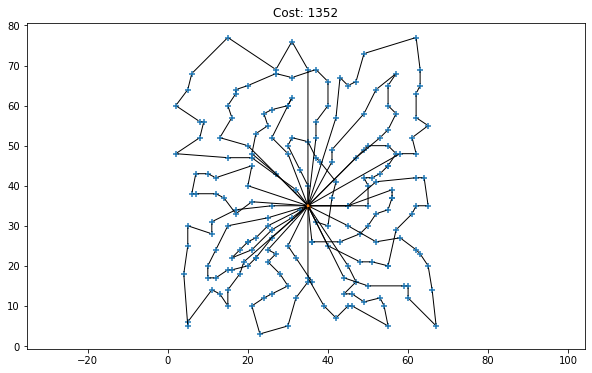

In [13]:
visualise_solution(data_dict, results_dict)

In [184]:
data_dict

{'num_dropoffs': 15,
 'num_vehicles': 3,
 'vehicle_capacity': 90,
 'warehouse_location': array([30., 40.]),
 'dropoffs_location_array': array([[37., 52.],
        [49., 49.],
        [52., 64.],
        [20., 26.],
        [40., 30.],
        [21., 47.],
        [17., 63.],
        [31., 62.],
        [52., 33.],
        [51., 21.],
        [42., 41.],
        [31., 32.],
        [ 5., 25.],
        [12., 42.],
        [36., 16.]]),
 'dropoffs_demand_array': array([ 7., 30., 16.,  9., 21., 15., 19., 23., 11.,  5., 19., 29., 23.,
        21., 10.])}

In [185]:
np.argmax(data_dict['dropoffs_demand_array'])

1